## Baseline 모델 구축을 위한 작업 코드
- baseline 모델보다 성능 좋은 모델 구현을 목표로 하면 됨!
- 모델 성능의 변화와 기준이 되는 역할이 필요해서 이 작업을 함

### 데이터셋 불러오기

In [89]:
# 행 축소 없이 다 보기
import pandas as pd

pd.set_option("display.max_rows", None)

import sys
import os

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), "../../../"))
)


In [90]:
master_data_df = pd.read_csv("../../../data/blinkit-dataset/blinkit_master_data_eda_mk_251224.csv")

In [91]:
master_data_df.columns

Index(['order_id', 'customer_id', 'order_date', 'promised_delivery_time',
       'actual_delivery_time', 'delivery_status', 'order_total',
       'payment_method', 'delivery_partner_id', 'store_id', 'product_id',
       'quantity', 'unit_price', 'product_name', 'category', 'brand', 'price',
       'mrp', 'margin_percentage', 'shelf_life_days', 'min_stock_level',
       'max_stock_level', 'delivery_time_minutes', 'distance_km',
       'reasons_if_delayed', 'feedback_id', 'rating', 'feedback_text',
       'feedback_category', 'sentiment', 'feedback_date', 'customer_name',
       'email', 'phone', 'address', 'area', 'pincode', 'registration_date',
       'customer_segment', 'total_orders', 'avg_order_value'],
      dtype='object')

---

### 가장 많이 주문된 카테고리 Top 5 찾기

In [92]:
top_categories = (
    master_data_df
    .groupby("category")["quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

top_categories

category
Dairy & Breakfast      1114
Household Care         1078
Pet Care               1003
Pharmacy                973
Fruits & Vegetables     966
Name: quantity, dtype: int64

---

# Daily_damand df 만들기 시작

### 시간 단위로 집계(일 단위)

In [93]:
category_df = master_data_df[
    master_data_df["category"] == "Dairy"
].copy()

category_df["order_date"] = pd.to_datetime(category_df["order_date"])

daily_demand = (
    category_df
    .groupby("order_date")["quantity"]
    .sum()
    .reset_index()
)

daily_demand

,order_date,quantity


In [94]:
master_data_df['order_date'].dtype

dtype('O')

### 카테고리 필터링

In [95]:
df_dairy = master_data_df[
    master_data_df['category'] == "Dairy & Breakfast"
].copy() # master_data_df의 category 컬럼을 복사해서 df_dairy로 재구성

df_dairy["order_date"] = pd.to_datetime(df_dairy["order_date"]) # datetime으로 타입 변환

In [96]:
df_dairy['order_date'].dtype

dtype('<M8[ns]')

### 일별 수요 데이터 생성

수요 예측에서 모델이 학습하는 내용:
1. “어제/지난주/지난달에
2. 이 카테고리가 얼마나 팔렸는지 →
(예측) 다음에 얼마나 팔릴까?”

그래서 👉 날짜 단위 수요만 남겨야 함

In [97]:
daily_demand = (
    df_dairy
    .groupby("order_date")["quantity"]
    .sum()
    .reset_index()
    .rename(columns={"quantity": "daily_quantity"})
)

daily_demand.head()

,order_date,daily_quantity
0,2023-03-16,1
1,2023-03-19,6
2,2023-03-23,3
3,2023-03-25,5
4,2023-03-26,2


## Feature 정의

In [98]:
master_data_df["discount_rate"] = (master_data_df["mrp"] - master_data_df["price"]) / master_data_df["mrp"]

In [99]:
daily_demand = (
    master_data_df
    .groupby(["order_date"])
    .agg(
        daily_quantity=("quantity", "sum"),
        avg_price=("price", "mean"),
        discount_rate=("discount_rate", "mean"),
        delivery_time_minutes=("delivery_time_minutes", "mean"),
        distance_km=("distance_km", "mean"),
        rating=("rating", "mean"),
        total_orders=("order_id", "nunique")
    )
    .reset_index()
)


In [100]:
daily_demand.head(20)

,order_date,daily_quantity,avg_price,discount_rate,delivery_time_minutes,distance_km,rating,total_orders
0,2023-03-16,18,397.825556,0.266665,5.444444,1.823333,3.111111,9
1,2023-03-17,9,498.118333,0.299999,1.166667,2.456667,3.166667,6
2,2023-03-18,16,586.631429,0.307142,3.000000,2.728571,3.285714,7
3,2023-03-19,13,597.395714,0.278571,4.142857,3.412857,3.428571,7
4,2023-03-20,4,632.772500,0.274996,8.000000,4.100000,4.250000,4
5,2023-03-21,25,537.990769,0.334617,7.153846,2.725385,3.153846,13
6,2023-03-22,10,416.361667,0.291669,0.833333,2.665000,3.666667,6
7,2023-03-23,8,685.330000,0.200000,3.400000,2.030000,3.000000,5
8,2023-03-24,7,441.267500,0.275000,4.750000,2.380000,4.000000,4
9,2023-03-25,20,498.098182,0.281822,4.545455,2.409091,3.272727,11


---

### 일별 수요 시계열 그래프

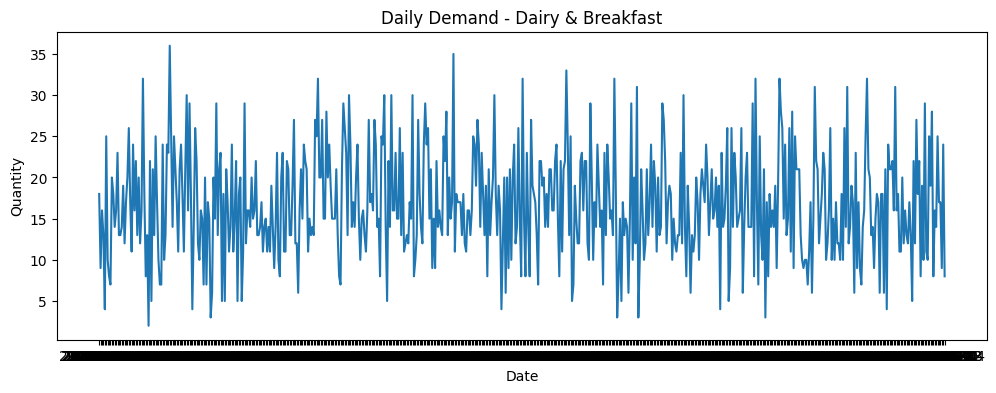

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(daily_demand["order_date"], daily_demand["daily_quantity"])
plt.title("Daily Demand - Dairy & Breakfast")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()

위 그래프에서 보는 포인트:  
- 전반적인 추세
- 갑자기 튀는 날 있는지
- 데이터 비어 보이는 구간

---

## baseline 모델 생성

### lag/rolling feature 만들기(모델 입력용)

과거 데이터(lag) -> 시계열 feature 설계

처음 7일은 NaN이 생기는 게 정상

In [102]:
daily_demand = daily_demand.sort_values("order_date").reset_index(drop=True)

daily_demand["lag_1"] = daily_demand['daily_quantity'].shift(1) # 과거 수요 feature 만듦
daily_demand["lag_7"] = daily_demand['daily_quantity'].shift(7) # 과거 수요 feature 만듦

daily_demand['rolling_mean_7'] = (
    daily_demand["daily_quantity"]
    .shift(1)
    .rolling(window=7)
    .mean()
)

# daily_demand

In [103]:
# NaN 제거
daily_demand = daily_demand.dropna().reset_index(drop=True)

### 이동평균 baseline 모델

이동 평균의 '이동' : 시간이 한 칸씩 "미끄러지듯" 이동  
예.
- 7일 이동 평균 - 8일 예측값 = (1~7일 수요 평균)
- 날짜가 하루 지나면
    - 어제까지 1~7일 평균
    - 오늘 2~8일 평균
-> 평균을 내는 구간(window)이 시간에 따라 이동(slide)해서 "이동 평균"이라 함  
---
이동 평균은
- 구현 제일 쉬움
- 과거 정보만 사용
- 설명 가능성 최고
- 시계열 예측의 최소 기준선
=> "이 모델보다만 잘 나오면 성공이다."가 됨
---
baseline_pred = rooling_mean_7
=> 최근 7일 평균 주문 수량을 오늘의 수요로 예측함을 의미

### baseline 모델 정의

In [104]:
daily_demand['baseline_pred'] = daily_demand['rolling_mean_7']

### 성능 비교

기준선 모델 성능 확보용

In [105]:
from sklearn.metrics import mean_absolute_error

valid = daily_demand.dropna()

mae = mean_absolute_error(
    valid["daily_quantity"],
    valid["baseline_pred"]
)

print("Baseline MAE: ", mae)

Baseline MAE:  5.640568537701759


여기까지의 작업은 “일별 수요 시계열을 시각화한 뒤, 과거 수요 기반 lag 및 이동평균 feature를 생성하여 이동평균을 기준선(baseline) 모델로 설정하였다.”로 설명할 수 있다

---

## 모델 코드 시작

### Linear Regression, Tree model test

In [106]:
from backend.features.time_features import add_time_features
from backend.models.linear_models import get_linear_models
from backend.models.tree_models import get_tree_models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --------- 모델링 파이프라인 ----------
df_model = add_time_features(daily_demand)

# NaN 없애기
df_model = df_model.dropna()


X = df_model.drop(columns=["daily_quantity", "order_date"])
y = df_model["daily_quantity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

In [107]:
# 모델 정의
models = get_linear_models()

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(name, mean_absolute_error(y_test, preds))


Linear 2.0324820083243953
Ridge 2.0255919816165475
Lasso 1.9904569013801139
ElasticNet 2.001691960443981


### 시각화

<목적>
- 수요 값이 한쪽으로 치우쳤는지 확인
- 이상치 여부 감각적으로 파악

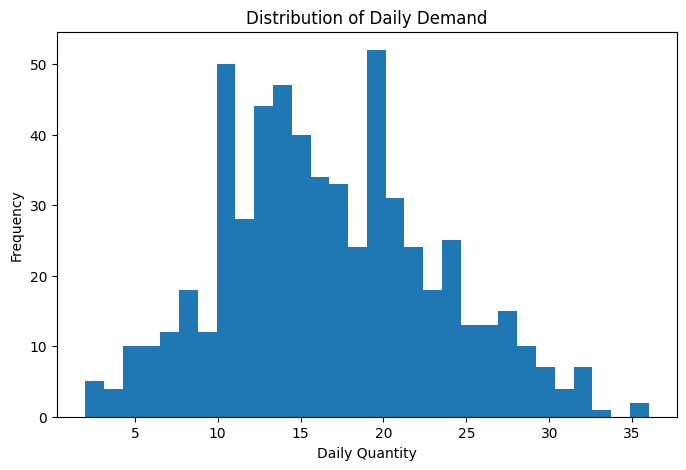

In [108]:
plt.figure(figsize=(8, 5))
plt.hist(y, bins=30)
plt.title("Distribution of Daily Demand")
plt.xlabel("Daily Quantity")
plt.ylabel("Frequency")
plt.show()


# 선형 모델별 MAE 비교 시각화

        model       MAE
2       Lasso  1.990457
3  ElasticNet  2.001692
1       Ridge  2.025592
0      Linear  2.032482


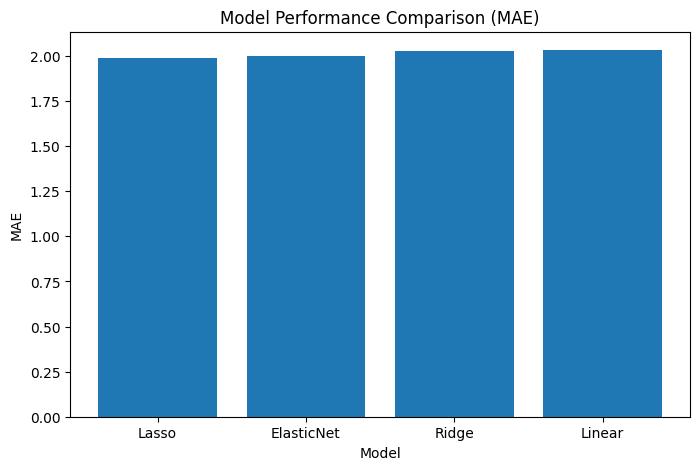

In [109]:
results = []

models = get_linear_models()

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)

    results.append({
        "model": name,
        "MAE": mae
    })

mae_df = pd.DataFrame(results).sort_values("MAE")

print(mae_df)

plt.figure(figsize=(8, 5))
plt.bar(mae_df["model"], mae_df["MAE"])
plt.title("Model Performance Comparison (MAE)")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.show()

### 그래프 해석
“선형 회귀 계열 모델들은 모두 유사한 성능을 보였으며, Lasso가 가장 낮은 MAE를 기록하였다. 이는 일부 변수만으로도 일별 수요를 충분히 설명할 수 있음을 시사한다.”

### Train, Test MAE 비교

In [110]:
for name, model in models.items():
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print(
        name,
        "Train MAE:", mean_absolute_error(y_train, train_preds),
        "Test MAE:", mean_absolute_error(y_test, test_preds)
    )


Linear Train MAE: 1.8373340985256212 Test MAE: 2.0324820083243953
Ridge Train MAE: 1.8359098619577956 Test MAE: 2.0255919816165475
Lasso Train MAE: 1.8344202883558127 Test MAE: 1.990456901380114
ElasticNet Train MAE: 1.8339802855708132 Test MAE: 2.001691960443981


---

## 왜 성능이 기대만큼 안 나오는지 분석하는 코드

In [111]:
# 이 모델, 진짜로 나쁜지 판단하는 방법
daily_demand["daily_quantity"].describe()

count    593.000000
mean      16.760540
std        6.450434
min        2.000000
25%       12.000000
50%       16.000000
75%       21.000000
max       36.000000
Name: daily_quantity, dtype: float64

### 사용한 feature 확인

In [112]:
X.columns

Index(['avg_price', 'discount_rate', 'delivery_time_minutes', 'distance_km',
       'rating', 'total_orders', 'lag_1', 'lag_7', 'rolling_mean_7',
       'baseline_pred', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

### NaN 제거 안 했는지 확인

In [113]:
daily_demand.isna().sum()

order_date               0
daily_quantity           0
avg_price                0
discount_rate            0
delivery_time_minutes    0
distance_km              0
rating                   0
total_orders             0
lag_1                    0
lag_7                    0
rolling_mean_7           0
baseline_pred            0
dtype: int64